In [35]:
from sklearn.cluster import KMeans, DBSCAN
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest

In [36]:
df = pd.read_csv('Liver Patient Dataset (LPD)_train.csv',encoding= 'unicode_escape')

df = df.dropna()
gender_mapping = {'Male': 0, 'Female': 1}
df['Gender of the patient'] = df['Gender of the patient'].map(gender_mapping)

df.columns = df.columns.str.strip()


In [37]:
df.columns

Index(['Age of the patient', 'Gender of the patient', 'Total Bilirubin',
       'Direct Bilirubin', 'Alkphos Alkaline Phosphotase',
       'Sgpt Alamine Aminotransferase', 'Sgot Aspartate Aminotransferase',
       'Total Protiens', 'ALB Albumin', 'A/G Ratio Albumin and Globulin Ratio',
       'Result'],
      dtype='object')

In [38]:
df.head(3)

,Age of the patient,Gender of the patient,Total Bilirubin,Direct Bilirubin,Alkphos Alkaline Phosphotase,Sgpt Alamine Aminotransferase,Sgot Aspartate Aminotransferase,Total Protiens,ALB Albumin,A/G Ratio Albumin and Globulin Ratio,Result
0,65.0,1,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62.0,0,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62.0,0,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1


In [39]:
check_df = df[['Age of the patient', 'Total Bilirubin',
       'Sgot Aspartate Aminotransferase', 'Total Protiens', 'ALB Albumin','Gender of the patient','Result']]

check_df = df.query('0.1 < `Total Bilirubin` < 1.2 and 3.4 < `ALB Albumin` < 5.4 and 5 < `Sgot Aspartate Aminotransferase` < 40 and 6.0 < `Total Protiens` < 8.3')

X = check_df.drop('Result', axis=1)
y = check_df['Result']
cluster_dfs = {}


In [40]:
from sklearn.metrics.pairwise import euclidean_distances

numerical_attributes = ['Age of the patient', 'Total Bilirubin', 'Sgot Aspartate Aminotransferase', 'Total Protiens', 'ALB Albumin']
test_X = check_df[numerical_attributes]

distances = euclidean_distances(test_X)

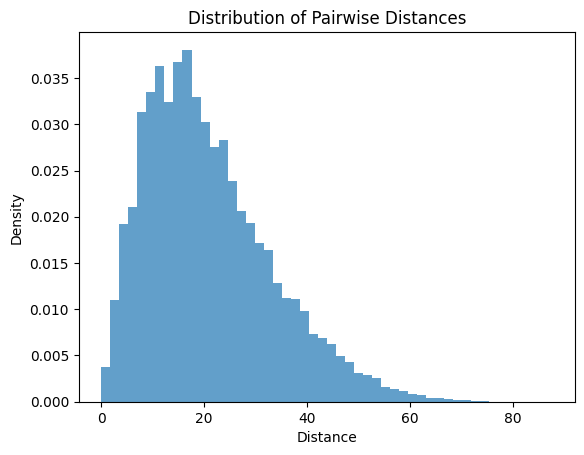

In [42]:
import matplotlib.pyplot as plt
import numpy as np

distances_flat = np.ravel(distances)

plt.hist(distances_flat, bins=50, density=True, alpha=0.7)
plt.title('Distribution of Pairwise Distances')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.show()

In [43]:
kmeans_5 = KMeans(n_clusters=5, random_state=42)
check_df['Cluster_KMeans_5'] = kmeans_5.fit_predict(X)
cluster_dfs['Cluster_Medical_5'] = check_df.copy()

In [44]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
check_df['Cluster_KMeans_3'] = kmeans_3.fit_predict(X)
cluster_dfs['Cluster_Medical_3'] = check_df.copy()

In [45]:
dbscan_5 = DBSCAN(eps=18.0, min_samples=5)
check_df['Cluster_DBSCAN_5'] = dbscan_5.fit_predict(X)
cluster_dfs['Cluster_DBSCAN_5'] = check_df[check_df['Cluster_DBSCAN_5'] != -1].copy()

In [46]:
dbscan_3 = DBSCAN(eps=18.0, min_samples=3)
check_df['Cluster_DBSCAN_3'] = dbscan_3.fit_predict(X)
cluster_dfs['Cluster_DBSCAN_3'] = check_df[check_df['Cluster_DBSCAN_3'] != -1].copy()

In [47]:
gmm_3 = GaussianMixture(n_components=3, random_state=42)
check_df['Cluster_GMM_3'] = gmm_3.fit_predict(X)
cluster_dfs['Cluster_GMM_3'] = check_df.copy()

In [48]:
gmm_5 = GaussianMixture(n_components=5, random_state=42)
check_df['Cluster_GMM_5'] = gmm_5.fit_predict(X)
cluster_dfs['Cluster_GMM_5'] = check_df.copy()

In [49]:
cluster_accuracies_albi = {}
cluster_accuracies_meld = {}
cluster_anomaly_scores = {}

In [50]:
classifiers = {
    'rf': RandomForestClassifier(random_state=42),
    'lr': LogisticRegression(random_state=42, max_iter=1000),
    'svc': LinearSVC(random_state=42, max_iter=1000),
    'nb': GaussianNB(),
    'knn': KNeighborsClassifier(n_neighbors=5),
    'nn': MLPClassifier(),
    'dt': DecisionTreeClassifier()
}

In [51]:
albi_columns = ['Total Bilirubin', 'ALB Albumin']
meld_columns = ['Total Bilirubin','Sgot Aspartate Aminotransferase','Total Protiens']

In [52]:
import warnings

In [54]:
cluster_accuracies_albi = {}
cluster_accuracies_meld = {}

anomalies_albi_dfs = {}
anomalies_meld_dfs = {}

warnings.filterwarnings('ignore')

for cluster_column, cluster_df in cluster_dfs.items():
    X_albi = cluster_df[albi_columns]
    y_albi = cluster_df['Result']
    
    X_meld = cluster_df[meld_columns]
    y_meld = cluster_df['Result']
    
    X_train_albi, X_test_albi, y_train_albi, y_test_albi = train_test_split(
        X_albi, y_albi, test_size=0.2, stratify=y_albi, random_state=42)
    
    X_train_meld, X_test_meld, y_train_meld, y_test_meld = train_test_split(
        X_meld, y_meld, test_size=0.2, stratify=y_meld, random_state=42)
    
    ensemble_model_albi = VotingClassifier(estimators=list(classifiers.items()), voting='hard')
    
    ensemble_model_albi.fit(X_train_albi, y_train_albi)
    
    predictions_albi = ensemble_model_albi.predict(X_test_albi)
    
    accuracy_albi = accuracy_score(y_test_albi, predictions_albi)
    cluster_accuracies_albi[cluster_column] = accuracy_albi
    
    iso_forest_albi = IsolationForest(contamination=0.1, random_state=42)  
    anomaly_scores_albi = iso_forest_albi.fit_predict(X_albi)
    
    anomalies_albi_df = cluster_df[anomaly_scores_albi == -1].copy()
    anomalies_albi_dfs[cluster_column] = anomalies_albi_df
    
    print(f"Accuracy for {cluster_column} (ALBI): {accuracy_albi}")
    print(f"Anomalies in {cluster_column} (ALBI): {len(anomalies_albi_df)} out of {len(X_albi)} data points")
    print("-----------------------------------")

    ensemble_model_meld = VotingClassifier(estimators=list(classifiers.items()), voting='hard')
    
    ensemble_model_meld.fit(X_train_meld, y_train_meld)
    
    predictions_meld = ensemble_model_meld.predict(X_test_meld)
    
    accuracy_meld = accuracy_score(y_test_meld, predictions_meld)
    cluster_accuracies_meld[cluster_column] = accuracy_meld
    
    iso_forest_meld = IsolationForest(contamination=0.1, random_state=42)  
    anomaly_scores_meld = iso_forest_meld.fit_predict(X_meld)
    
    anomalies_meld_df = cluster_df[anomaly_scores_meld == -1].copy()
    anomalies_meld_dfs[cluster_column] = anomalies_meld_df
    
    print(f"Accuracy for {cluster_column} (MELD): {accuracy_meld}")
    print(f"Anomalies in {cluster_column} (MELD): {len(anomalies_meld_df)} out of {len(X_meld)} data points")
    print("-------------------------------------------------------------------")

Accuracy for Cluster_Medical_5 (ALBI): 0.5907928388746803
Anomalies in Cluster_Medical_5 (ALBI): 371 out of 3907 data points
-----------------------------------
Accuracy for Cluster_Medical_5 (MELD): 0.8785166240409207
Anomalies in Cluster_Medical_5 (MELD): 358 out of 3907 data points
-------------------------------------------------------------------
Accuracy for Cluster_Medical_3 (ALBI): 0.6342710997442456
Anomalies in Cluster_Medical_3 (ALBI): 371 out of 3907 data points
-----------------------------------
Accuracy for Cluster_Medical_3 (MELD): 0.9654731457800512
Anomalies in Cluster_Medical_3 (MELD): 358 out of 3907 data points
-------------------------------------------------------------------
Accuracy for Cluster_DBSCAN_5 (ALBI): 0.5818414322250639
Anomalies in Cluster_DBSCAN_5 (ALBI): 371 out of 3907 data points
-----------------------------------
Accuracy for Cluster_DBSCAN_5 (MELD): 0.840153452685422
Anomalies in Cluster_DBSCAN_5 (MELD): 358 out of 3907 data points
-----------

In [55]:
# df.query('0.1 < `Total Bilirubin` < 1.2 and 3.4 < `ALB Albumin` < 5.4 and 5 < `Sgot Aspartate Aminotransferase` < 40 and 6.0 < `Total Protiens` < 8.3')
# df.query('0.1 < `Total Bilirubin` < 1.2 and 3.4 < `ALB Albumin` < 5.4 and 5 < `Sgot Aspartate Aminotransferase` < 40 and 6.0 < `Total Protiens` < 8.3')


In [56]:
anomalies_meld_df.query('Cluster_DBSCAN_3 == -1 or Cluster_DBSCAN_5 == -1')

,Age of the patient,Gender of the patient,Total Bilirubin,Direct Bilirubin,Alkphos Alkaline Phosphotase,Sgpt Alamine Aminotransferase,Sgot Aspartate Aminotransferase,Total Protiens,ALB Albumin,A/G Ratio Albumin and Globulin Ratio,Result,Cluster_KMeans_5,Cluster_KMeans_3,Cluster_DBSCAN_5,Cluster_DBSCAN_3,Cluster_GMM_3,Cluster_GMM_5


In [57]:
anomalies_albi_df.columns

Index(['Age of the patient', 'Gender of the patient', 'Total Bilirubin',
       'Direct Bilirubin', 'Alkphos Alkaline Phosphotase',
       'Sgpt Alamine Aminotransferase', 'Sgot Aspartate Aminotransferase',
       'Total Protiens', 'ALB Albumin', 'A/G Ratio Albumin and Globulin Ratio',
       'Result', 'Cluster_KMeans_5', 'Cluster_KMeans_3', 'Cluster_DBSCAN_5',
       'Cluster_DBSCAN_3', 'Cluster_GMM_3', 'Cluster_GMM_5'],
      dtype='object')

In [58]:
anomalies_albi_df.head(5)

,Age of the patient,Gender of the patient,Total Bilirubin,Direct Bilirubin,Alkphos Alkaline Phosphotase,Sgpt Alamine Aminotransferase,Sgot Aspartate Aminotransferase,Total Protiens,ALB Albumin,A/G Ratio Albumin and Globulin Ratio,Result,Cluster_KMeans_5,Cluster_KMeans_3,Cluster_DBSCAN_5,Cluster_DBSCAN_3,Cluster_GMM_3,Cluster_GMM_5
124,28.0,0,0.6,0.1,177.0,36.0,29.0,6.9,4.1,1.4,2,0,0,0,0,0,4
203,21.0,0,1.0,0.3,142.0,27.0,21.0,6.4,3.5,1.2,2,0,0,0,0,0,0
217,49.0,0,1.1,0.5,159.0,30.0,31.0,7.0,4.3,1.5,1,0,0,0,0,0,0
223,50.0,0,1.1,0.3,175.0,20.0,19.0,7.1,4.5,1.7,2,0,0,0,0,0,4
238,35.0,1,0.9,0.2,190.0,40.0,35.0,7.3,4.7,1.8,2,4,0,0,0,0,4


In [59]:
probability_scores = gmm_5.predict_proba(df.loc[[124]].drop('Result', axis=1))


In [60]:
print(probability_scores)

[[5.94095118e-149 0.00000000e+000 0.00000000e+000 0.00000000e+000
  1.00000000e+000]]


In [61]:
for cluster_column in cluster_dfs.keys():
    anomalies_albi_count = len(anomalies_albi_dfs[cluster_column])
    anomalies_meld_count = len(anomalies_meld_dfs[cluster_column])
    print(cluster_column)
    print(f"Anomalies in {cluster_column} (ALBI): {anomalies_albi_count}")
    print(f"Anomalies in {cluster_column} (MELD): {anomalies_meld_count}")

Cluster_Medical_5
Anomalies in Cluster_Medical_5 (ALBI): 371
Anomalies in Cluster_Medical_5 (MELD): 358
Cluster_Medical_3
Anomalies in Cluster_Medical_3 (ALBI): 371
Anomalies in Cluster_Medical_3 (MELD): 358
Cluster_DBSCAN_5
Anomalies in Cluster_DBSCAN_5 (ALBI): 371
Anomalies in Cluster_DBSCAN_5 (MELD): 358
Cluster_DBSCAN_3
Anomalies in Cluster_DBSCAN_3 (ALBI): 371
Anomalies in Cluster_DBSCAN_3 (MELD): 358
Cluster_GMM_3
Anomalies in Cluster_GMM_3 (ALBI): 371
Anomalies in Cluster_GMM_3 (MELD): 358
Cluster_GMM_5
Anomalies in Cluster_GMM_5 (ALBI): 371
Anomalies in Cluster_GMM_5 (MELD): 358


In [62]:
anomalies_albi_df.head(3)

,Age of the patient,Gender of the patient,Total Bilirubin,Direct Bilirubin,Alkphos Alkaline Phosphotase,Sgpt Alamine Aminotransferase,Sgot Aspartate Aminotransferase,Total Protiens,ALB Albumin,A/G Ratio Albumin and Globulin Ratio,Result,Cluster_KMeans_5,Cluster_KMeans_3,Cluster_DBSCAN_5,Cluster_DBSCAN_3,Cluster_GMM_3,Cluster_GMM_5
124,28.0,0,0.6,0.1,177.0,36.0,29.0,6.9,4.1,1.4,2,0,0,0,0,0,4
203,21.0,0,1.0,0.3,142.0,27.0,21.0,6.4,3.5,1.2,2,0,0,0,0,0,0
217,49.0,0,1.1,0.5,159.0,30.0,31.0,7.0,4.3,1.5,1,0,0,0,0,0,0


In [63]:
#Common anamolies

In [64]:
key_columns = ["Age of the patient", "Gender of the patient", "Result"]

for cluster_column in cluster_dfs.keys():
    anomalies_albi = anomalies_albi_dfs[cluster_column][key_columns]
    anomalies_meld = anomalies_meld_dfs[cluster_column][key_columns]

    common_anomalies = pd.merge(anomalies_albi, anomalies_meld, on=key_columns)

    print(f"Common anomalies count in {cluster_column}: {len(common_anomalies)}")
    print(common_anomalies)
    print("-----------------------------------")

Common anomalies count in Cluster_Medical_5: 796
     Age of the patient  Gender of the patient  Result
0                  21.0                      0       2
1                  49.0                      0       1
2                  49.0                      0       1
3                  49.0                      0       1
4                  50.0                      0       2
..                  ...                    ...     ...
791                45.0                      1       1
792                45.0                      1       1
793                45.0                      1       1
794                45.0                      1       1
795                45.0                      1       1

[796 rows x 3 columns]
-----------------------------------
Common anomalies count in Cluster_Medical_3: 796
     Age of the patient  Gender of the patient  Result
0                  21.0                      0       2
1                  49.0                      0       1
2                

In [65]:
anomalies_albi_df['Total Bilirubin'].describe()

count    371.000000
mean       0.852561
std        0.228184
min        0.500000
25%        0.600000
50%        1.000000
75%        1.000000
max        1.100000
Name: Total Bilirubin, dtype: float64

In [66]:
# df.reset_index(drop=True, inplace=True)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# model_rf = RandomForestClassifier(random_state=42)
# model_lr = LogisticRegression(random_state=42, max_iter=1000) 
# model_svc = LinearSVC(random_state=42, max_iter=1000) 
# model_naive_bayes = GaussianNB()
# model_knn = KNeighborsClassifier(n_neighbors=5)
# model_neural_network = MLPClassifier()
# model_decision_tree = DecisionTreeClassifier()

# global_voting_model = VotingClassifier(estimators=[
#     ('rf', model_rf),
#     ('lr',model_lr),
#     ('svc', model_svc),
#     ('nb', model_naive_bayes),
#     ('knn', model_knn),
#     ('nn', model_neural_network),
#     ('dt', model_decision_tree)
# ], voting='hard')

# global_voting_model.fit(X_train, y_train)
# global_predictions = global_voting_model.predict(X_test)

# overall_accuracy = accuracy_score(y_test, global_predictions)
# classification_report_result = classification_report(y_test, global_predictions)


# print(f"Overall Accuracy: {overall_accuracy}")
# # print("Classification Report:")

In [67]:
# cluster_accuracies = []

# # Iterate over each cluster column
# for cluster_column in ['Cluster_KMeans_3', 'Cluster_KMeans_5', 'Cluster_DBSCAN', 'Cluster_Spectral_3', 'Cluster_Spectral_5']:
#     cluster_predictions = df[cluster_column]
    
#     # Filter the true labels corresponding to the samples with assigned clusters
#     true_labels = y_test[df[cluster_column] != -1]  # Assuming -1 represents noise for DBSCAN
    
#     # Filter the predicted labels for the same samples
#     predicted_labels = cluster_predictions[df[cluster_column] != -1]
    
#     # Calculate accuracy for the current cluster
#     cluster_accuracy = accuracy_score(true_labels, predicted_labels)
    
#     # Append accuracy to the list
#     cluster_accuracies.append((cluster_column, cluster_accuracy))

# # Print accuracy for each cluster
# for cluster, accuracy in cluster_accuracies:
#     print(f"Accuracy for {cluster}: {accuracy}")

In [68]:
# albi_columns = ['Total Bilirubin', 'ALB Albumin']
# meld_columns = ['Total Bilirubin','Sgot Aspartate Aminotransferase','Total Protiens']


# cluster_dfs = {}
# for cluster_column in ['Cluster_KMeans_3', 'Cluster_KMeans_5', 'Cluster_DBSCAN', 'Cluster_Spectral_3', 'Cluster_Spectral_5']:
#     cluster_mask = df[cluster_column] != -1  # Assuming -1 represents noise for DBSCAN
#     cluster_dfs[cluster_column] = df[cluster_mask].copy()

# # Dictionary to store accuracy for each cluster
# cluster_accuracies = {}

# # Iterate over each cluster DataFrame
# for cluster_column, cluster_df in cluster_dfs.items():
#     # Extract necessary columns for liver disease prediction
#     X_cluster = cluster_df[albi_columns + meld_columns]
#     y_cluster = cluster_df['Result']  # Assuming 'Result' is the target column
    
#     # Split the data
#     X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(
#         X_cluster, y_cluster, test_size=0.2, stratify=y_cluster, random_state=42)
    
#     # Train the model (you can use any classifier, for example, RandomForestClassifier)
#     model = RandomForestClassifier(random_state=42)
#     model.fit(X_train_cluster, y_train_cluster)
    
#     # Make predictions
#     predictions_cluster = model.predict(X_test_cluster)
    
#     # Calculate accuracy
#     accuracy_cluster = accuracy_score(y_test_cluster, predictions_cluster)
#     cluster_accuracies[cluster_column] = accuracy_cluster
    
#     # Print accuracy for the current cluster
#     print(f"Accuracy for {cluster_column}: {accuracy_cluster}")

# # Print overall accuracy for all clusters
# overall_accuracy = sum(cluster_accuracies.values()) / len(cluster_accuracies)
# print(f"Overall Accuracy for all clusters: {overall_accuracy}")

In [69]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# Assuming your dataset is stored in a DataFrame named 'df'
# Exclude the 'Result' column for unsupervised clustering
features = df.drop('Result', axis=1)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply spectral clustering
n_clusters = 3  # You need to specify the number of clusters (you can adjust this based on your understanding of the data)
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
df['Cluster'] = spectral.fit_predict(scaled_features)

# Visualize the results (2D plot for simplicity, considering only the first two features)
# plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=df['Cluster'], cmap='viridis')
# plt.title('Spectral Clustering Results')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.show()

In [70]:
df.head(3)

,Age of the patient,Gender of the patient,Total Bilirubin,Direct Bilirubin,Alkphos Alkaline Phosphotase,Sgpt Alamine Aminotransferase,Sgot Aspartate Aminotransferase,Total Protiens,ALB Albumin,A/G Ratio Albumin and Globulin Ratio,Result,Cluster
0,65.0,1,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1,0
1,62.0,0,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1,0
2,62.0,0,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1,0


In [71]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

features = df.drop('Result', axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(scaled_features, df['Result'], test_size=0.2, random_state=42)

n_clusters = 3 
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
train_clusters = spectral.fit_predict(X_train)

test_clusters = spectral.fit_predict(X_test)

def map_clusters_to_labels(clusters, true_labels):
    cluster_mapping = {}
    for cluster_label in set(clusters):
        indices = clusters == cluster_label
        majority_vote = true_labels[indices].mode().iloc[0]
        cluster_mapping[cluster_label] = majority_vote
    return cluster_mapping

train_mapping = map_clusters_to_labels(train_clusters, y_train)
test_mapping = map_clusters_to_labels(test_clusters, y_test)

df['Cluster'] = spectral.fit_predict(scaled_features)
df['Cluster_Label'] = df['Cluster'].map(test_mapping)

accuracy = accuracy_score(df['Result'], df['Cluster_Label'])
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 71.72%


In [72]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

features = df.drop('Result', axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(scaled_features, df['Result'], test_size=0.2, random_state=42)

n_clusters = 5 
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
train_clusters = spectral.fit_predict(X_train)

test_clusters = spectral.fit_predict(X_test)

def map_clusters_to_labels(clusters, true_labels):
    cluster_mapping = {}
    for cluster_label in set(clusters):
        indices = clusters == cluster_label
        majority_vote = true_labels[indices].mode().iloc[0]
        cluster_mapping[cluster_label] = majority_vote
    return cluster_mapping

train_mapping = map_clusters_to_labels(train_clusters, y_train)
test_mapping = map_clusters_to_labels(test_clusters, y_test)


df['Cluster'] = spectral.fit_predict(scaled_features)
df['Cluster_Label'] = df['Cluster'].map(test_mapping)

accuracy = accuracy_score(df['Result'], df['Cluster_Label'])
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 71.72%
